# Introdução

O objetivo desse notebook é explorar uma base de dados de cerveja. Essas informações são extraidas da API https://punkapi.com/documentation/v2, processadas e armazenadas no AWS Redshift.

Primeiramente iremos fazer algumas análises exploratórias na base com objetivo de entender os dados.

Depois iremos testar modelos de aprendizado de máquina para tentar prever o IBU das cervejas.

In [8]:
import json
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import  StandardScaler
from sklearn.feature_selection import SelectKBest

from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import  RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  GradientBoostingRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import warnings
warnings.filterwarnings('ignore')

## Carregando os dados do arquivo

In [9]:
attributes = ['name', 'abv', 'ibu', 'target_fg',
              'target_og', 'ebc', 'srm', 'ph']

beer_df = pd.read_json('punk_ds.json')
beer_df = beer_df[attributes]
beer_df

,name,abv,ibu,target_fg,target_og,ebc,srm,ph
0,Buzz,4.5,60.0,1010.0,1044.0,20.0,10.0,4.4
1,Trashy Blonde,4.1,41.5,1010.0,1041.7,15.0,15.0,4.4
2,Berliner Weisse With Yuzu - B-Sides,4.2,8.0,1007.0,1040.0,8.0,4.0,3.2
3,Pilsen Lager,6.3,55.0,1012.0,1060.0,30.0,15.0,4.4
4,Avery Brown Dredge,7.2,59.0,1027.0,1069.0,10.0,5.0,4.4
...,...,...,...,...,...,...,...,...
320,Jinx Pale Ale,4.7,35.0,1008.0,1043.0,13.0,7.0,4.6
321,Jet Trash,6.9,65.0,1008.0,1060.0,18.0,9.0,4.6
322,Interstate Vienna Lager.,5.0,25.0,1007.0,1045.0,14.0,7.0,4.2
323,Fools Gold Dortmunder Lager,5.6,32.0,1009.0,1052.0,11.0,6.0,4.2


In [10]:
attributes = beer_df.select_dtypes(include=[np.number]).columns
beer_df = beer_df[attributes]
beer_df

,abv,ibu,target_fg,target_og,ebc,srm,ph
0,4.5,60.0,1010.0,1044.0,20.0,10.0,4.4
1,4.1,41.5,1010.0,1041.7,15.0,15.0,4.4
2,4.2,8.0,1007.0,1040.0,8.0,4.0,3.2
3,6.3,55.0,1012.0,1060.0,30.0,15.0,4.4
4,7.2,59.0,1027.0,1069.0,10.0,5.0,4.4
...,...,...,...,...,...,...,...
320,4.7,35.0,1008.0,1043.0,13.0,7.0,4.6
321,6.9,65.0,1008.0,1060.0,18.0,9.0,4.6
322,5.0,25.0,1007.0,1045.0,14.0,7.0,4.2
323,5.6,32.0,1009.0,1052.0,11.0,6.0,4.2


In [11]:
beer_df.dtypes

abv          float64
ibu          float64
target_fg    float64
target_og    float64
ebc          float64
srm          float64
ph           float64
dtype: object

# KDD

### Estatisticas da base de dados

In [12]:
beer_df.describe().T

,count,mean,std,min,25%,50%,75%,max
abv,325.0,7.906462,4.682521,0.5,5.200,7.2,9.0,55.0
ibu,320.0,65.243750,92.403699,0.0,35.000,50.0,70.0,1157.0
target_fg,324.0,1015.169753,14.488349,1000.0,1010.000,1012.0,1015.0,1125.0
target_og,324.0,1067.530556,27.142109,1007.0,1048.375,1065.0,1080.0,1157.0
ebc,319.0,66.228527,92.306210,2.0,15.000,28.0,70.5,600.0
srm,319.0,33.581881,46.505684,1.0,8.000,15.0,40.0,305.0
ph,323.0,4.641486,4.166788,3.2,4.400,4.4,4.4,79.0


**Traramento de Campos Vazios**

Quantidade de campos vazios de cada atributo

In [13]:
beer_df.isna().sum()

abv          0
ibu          5
target_fg    1
target_og    1
ebc          6
srm          6
ph           2
dtype: int64

Removendo campos vazios.

In [14]:
# Remove rows with empty IBU
beer_df = beer_df.dropna(subset=['ibu'])

# Replace empty rows with using the average
beer_df = beer_df.fillna(beer_df.mean())

print(beer_df.shape)
beer_df.isna().sum()

(320, 7)


abv          0
ibu          0
target_fg    0
target_og    0
ebc          0
srm          0
ph           0
dtype: int64

**Histogram dos Atributos Numericos**

array([[<AxesSubplot:title={'center':'abv'}>,
        <AxesSubplot:title={'center':'ibu'}>,
        <AxesSubplot:title={'center':'target_fg'}>,
        <AxesSubplot:title={'center':'target_og'}>],
       [<AxesSubplot:title={'center':'ebc'}>,
        <AxesSubplot:title={'center':'srm'}>,
        <AxesSubplot:title={'center':'ph'}>, <AxesSubplot:>]],
      dtype=object)

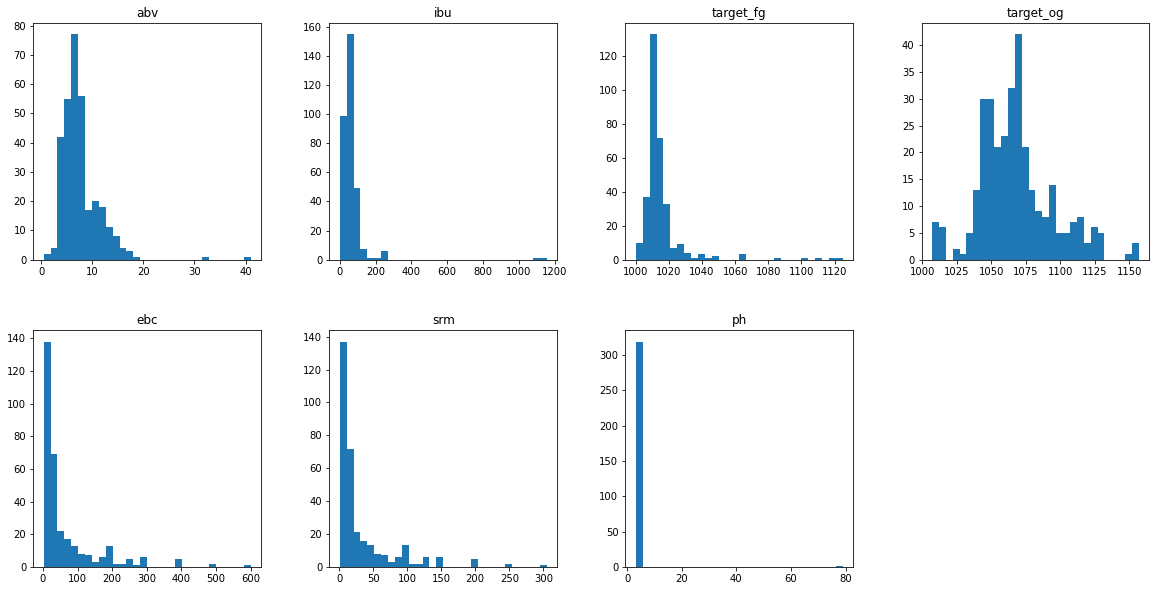

In [15]:
beer_df.hist(figsize=(20,10), grid=False, layout=(2, 4), bins = 30)

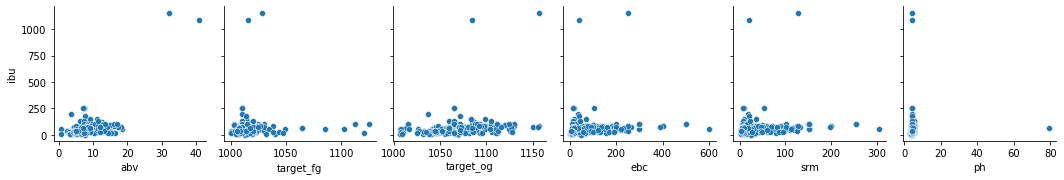

In [16]:
pp = sns.pairplot(data=beer_df,
                  y_vars=['ibu'],
                  x_vars=['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph'])


Olhando para o gráfico acima, podemos observar que duas instâncias aparecem com IBU bastante elevado quando comparadas com as outras instâncias. 

Um fenômeno similar ocorre no PH, mas nesse caso ocorre com apenas uma instância.

Essas instâncias dificultam a análise do gráfico de pares. Dessa forma iremos removê-las da base manualmente e posteriormente iremos utilizar técnicas mais robustas para remoção de outilers e investigar mais seus impactos no modelos de aprendizado de máquina.

In [17]:
beer_no_out_df = beer_df[((beer_df['ibu'] < 500) & (beer_df['ph'] < 20))]
beer_no_out_df.shape

(317, 7)

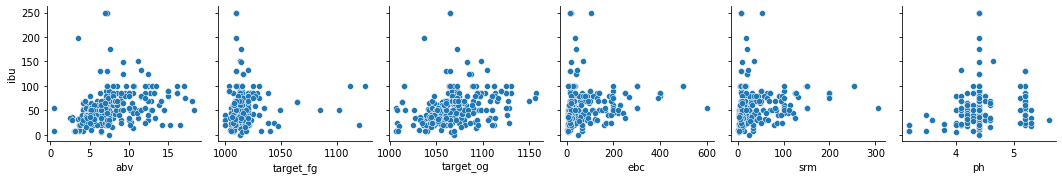

In [18]:
pp = sns.pairplot(data=beer_no_out_df,
                  y_vars=['ibu'],
                  x_vars=['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph'])

Após a remoção das três instâncias, podemos visualizar melhor a correlação de cada atributo com o IBU. Porém, ainda é possivel observar alguns pontos que parecem ser outliers. Isso reforça a intuição de que poderiamos utilizar um método de remoção de outliers mais robusto.

**Matriz de Correlacao**

<AxesSubplot:>

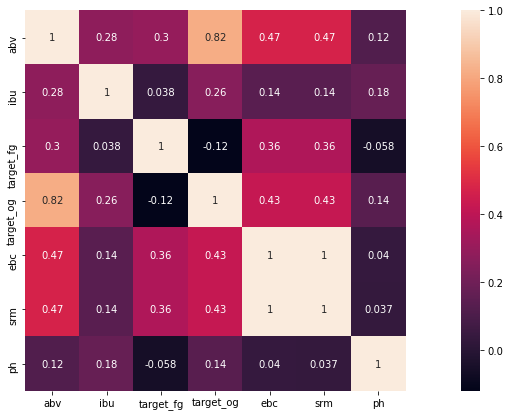

In [19]:
plt.figure(figsize=(20,7))
sns.heatmap(beer_no_out_df.corr(), annot=True, square=True)

O gráfico acima mostra que os atributos com maior grau de correlação com o IBU são o ABV e Target OG. Porém parecem ser uma correlação fraca se comparadas com as corrlações ABV x Target OG e EBC x SRM. 

<AxesSubplot:xlabel='abv', ylabel='target_og'>

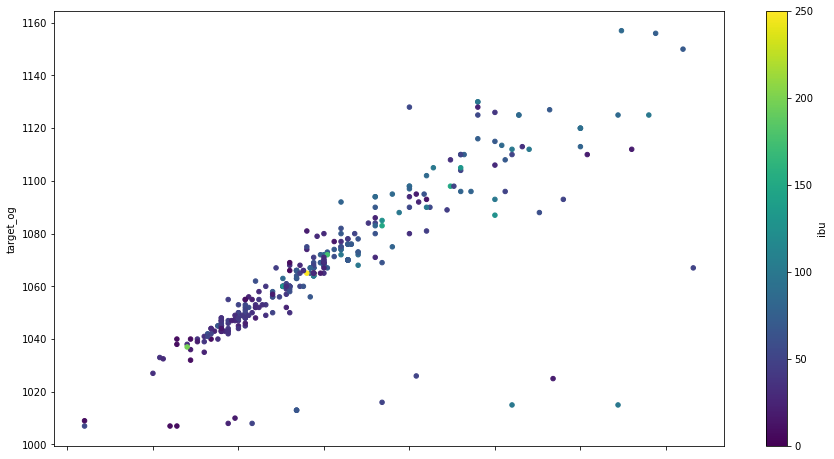

In [20]:
beer_no_out_df.plot.scatter(figsize=(15,8), x='abv', y='target_og',c='ibu', colormap='viridis')

No gráfico acima, cada pondo representa uma instância na base. O eixo X representa o ABV enquanto o eixo Y representa Target OG. A cor dos campos representa o IBU.

É possível observar que existes uma correlção alta entre os campos ABV e Target OG.

Os pontos mais escuros (menor IBU) se concentram no canto esquerdo inferior que representa menor ABV e Target OG.

# Modelo de Machine Learning

In [21]:
X_att = ['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph']

X = beer_no_out_df[X_att].values
X = StandardScaler().fit_transform(X)
Y = beer_no_out_df['ibu'].values

### Experimento com Regressores

Nesse experimento, testamos os seguintes algorítimos de regressão:
- LinearRegression
- KNeighborsRegressor
- GradientBoostingRegressor
- RandomForestRegressor


In [22]:
def predict_ipu(model, X, Y):
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42)

    feature_importances = []

    # Train the model using the training sets
    model.fit(X_train, y_train)

    if (isinstance(model, GradientBoostingRegressor) or
        isinstance(model, RandomForestRegressor)):
        feature_importances.append(model.feature_importances_)

    y_pred = model.predict(X_test)

    # The mean squared error
    print(type(model).__name__)
    print('Mean squared error: %.2f'
          % mean_squared_error(y_test, y_pred))
    
    print('\n')

    return np.array(feature_importances).mean(axis=0)
 
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')

In [23]:
predict_ipu(LinearRegression(normalize=True), X, Y)

predict_ipu(KNeighborsRegressor(n_neighbors = 4), X, Y)

gbr_feature_importances = predict_ipu(GradientBoostingRegressor(), X, Y)

rdf_feature_importances = predict_ipu(RandomForestRegressor(), X, Y)

LinearRegression
Mean squared error: 1314.10


KNeighborsRegressor
Mean squared error: 1414.14


GradientBoostingRegressor
Mean squared error: 966.05


RandomForestRegressor
Mean squared error: 917.71




Nesse experimento, podemos observar que os regressores GradientBoostingRegressor e RandomForestRegressor apresentaram os melhores resultados.

Os gráficos seguintes mostram o grau de importância de cada atributo para a predição do IBU onde é possível confirmar a correlação do ABV e Target OG com o IBU.

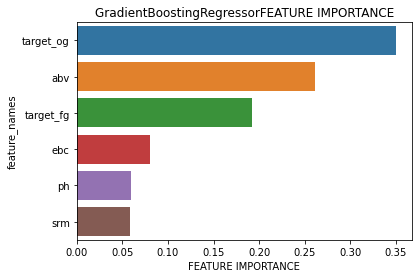

In [24]:
plot_feature_importance(gbr_feature_importances, X_att, 'GradientBoostingRegressor')

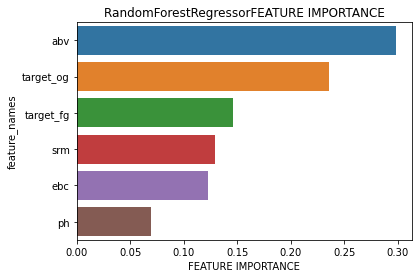

In [25]:
plot_feature_importance(rdf_feature_importances, X_att, 'RandomForestRegressor')

## Remoção de Outilers

Como mencionado anteriormente, algumas instâncias parecem ser outilers. O gráfico abaixo ilustra a distruibuição de cada atributo onde é possível observar pontos fora do padrão.

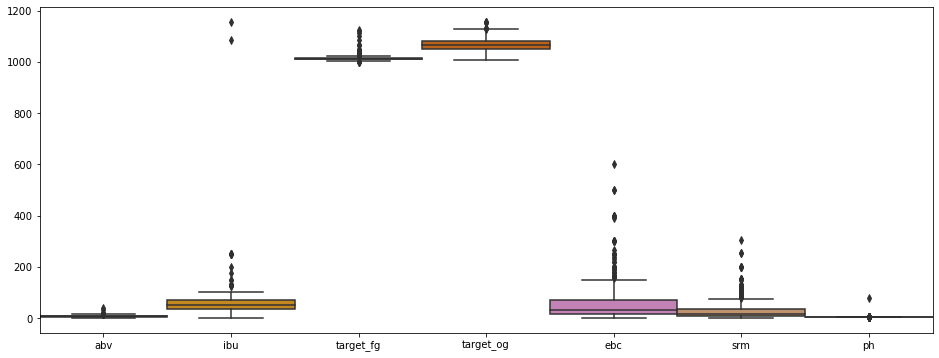

In [26]:
plt.figure(figsize=(16, 6))
bplot = sns.boxplot(data=beer_df, width=1, palette="colorblind")

Desta forma, vamos utilizar o IQR para remover outilers e analisar se há melhora no resultado dos experimentos.

In [27]:
beer_noout_df = beer_df.copy()

for _att in attributes:
    att = beer_noout_df[_att]
    removed_outliers = att.between(att.quantile(.05), att.quantile(.95))
    index_names = beer_noout_df[~removed_outliers].index
    beer_noout_df.drop(index_names, inplace=True)

print('Dataset original:', len(beer_df))
print('Dataset sem outilers:', len(beer_noout_df))

Dataset original: 320
Dataset sem outilers: 175


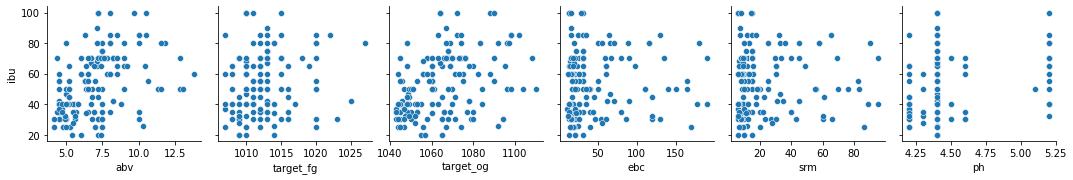

In [28]:
pp = sns.pairplot(data=beer_noout_df,
                  y_vars=['ibu'],
                  x_vars=['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph'])

<AxesSubplot:>

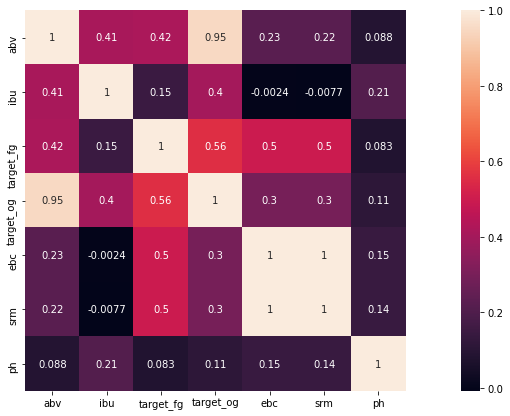

In [29]:
plt.figure(figsize=(20,7))
sns.heatmap(beer_noout_df.corr(), annot=True, square=True)

<AxesSubplot:xlabel='abv', ylabel='target_og'>

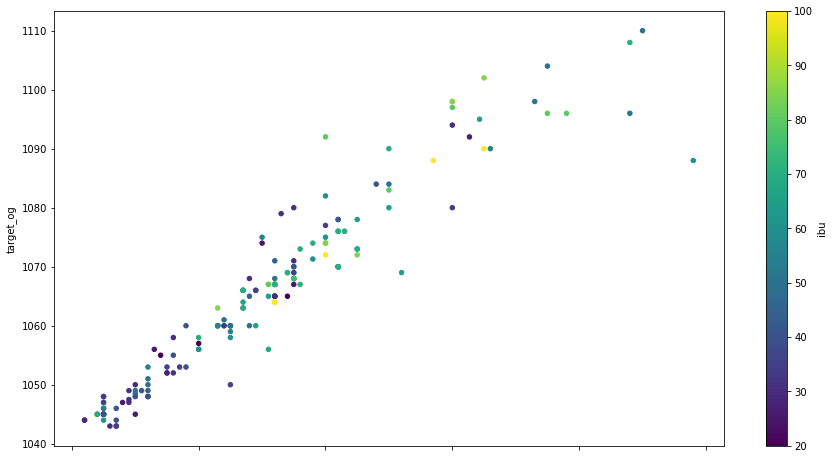

In [30]:
beer_noout_df.plot.scatter(figsize=(15,8), x='abv', y='target_og',c='ibu', colormap='viridis')

In [31]:
X = beer_noout_df[X_att].values
X = StandardScaler().fit_transform(X)
Y = beer_noout_df['ibu'].values

In [32]:
gbr_feature_importances = predict_ipu(GradientBoostingRegressor(), X, Y)

rdf_feature_importances = predict_ipu(RandomForestRegressor(), X, Y)

GradientBoostingRegressor
Mean squared error: 346.69


RandomForestRegressor
Mean squared error: 358.11




Como podemos observar, houve uma diminuição no erro médio dos modelos após a remoção dos outliers.

## Experimento com Classificadores

Outra forma de analisar o problema de prever o IBU é utizar classificadores. Nesse caso, iresmo discretizar o IBU em escala te tamanho 10.

In [33]:
beer_discret_df = beer_noout_df.copy()
beer_discret_df.ibu.describe()

count    175.000000
mean      55.062857
std       20.058006
min       20.000000
25%       38.500000
50%       55.000000
75%       70.000000
max      100.000000
Name: ibu, dtype: float64

In [34]:
min_ibu = beer_discret_df.ibu.min()
max_ibu = beer_discret_df.ibu.max()

bins = list(range(int(min_ibu), int(max_ibu) + 10, 10))
bins_label = bins[1:-1]

beer_discret_df['disc_ibu'] = pd.cut(beer_discret_df['ibu'], bins, include_lowest= True)
beer_discret_df

,abv,ibu,target_fg,target_og,ebc,srm,ph,disc_ibu
0,4.5,60.0,1010.0,1044.0,20.0,10.0,4.4,"(50.0, 60.0]"
3,6.3,55.0,1012.0,1060.0,30.0,15.0,4.4,"(50.0, 60.0]"
7,4.7,40.0,1010.0,1046.0,12.0,6.0,4.4,"(30.0, 40.0]"
9,7.5,75.0,1013.0,1068.0,22.0,11.0,4.4,"(70.0, 80.0]"
10,7.3,30.0,1020.0,1079.0,120.0,60.0,4.4,"(19.999, 30.0]"
...,...,...,...,...,...,...,...,...
319,7.4,20.0,1009.0,1065.0,20.0,10.0,4.4,"(19.999, 30.0]"
320,4.7,35.0,1008.0,1043.0,13.0,7.0,4.6,"(30.0, 40.0]"
321,6.9,65.0,1008.0,1060.0,18.0,9.0,4.6,"(60.0, 70.0]"
322,5.0,25.0,1007.0,1045.0,14.0,7.0,4.2,"(19.999, 30.0]"


In [35]:
def predict_ipu_classifier(model, X, Y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))

In [36]:
X = beer_discret_df[X_att].values
X = StandardScaler().fit_transform(X)
Y = beer_discret_df['disc_ibu'].values
Y = np.array([str(y) for y in Y])

In [37]:
predict_ipu_classifier(KNeighborsClassifier(n_neighbors=3), X, Y)

                precision    recall  f1-score   support

(19.999, 30.0]       0.38      0.71      0.50         7
  (30.0, 40.0]       1.00      0.38      0.55         8
  (40.0, 50.0]       0.00      0.00      0.00         6
  (50.0, 60.0]       0.75      0.60      0.67         5
  (60.0, 70.0]       0.31      0.67      0.42         6
  (70.0, 80.0]       0.00      0.00      0.00         1
  (80.0, 90.0]       0.00      0.00      0.00         2
 (90.0, 100.0]       0.00      0.00      0.00         0

      accuracy                           0.43        35
     macro avg       0.31      0.29      0.27        35
  weighted avg       0.47      0.43      0.39        35



In [38]:
predict_ipu_classifier(RandomForestClassifier(max_depth=10, random_state=0), X, Y)

                precision    recall  f1-score   support

(19.999, 30.0]       0.50      0.43      0.46         7
  (30.0, 40.0]       0.57      0.50      0.53         8
  (40.0, 50.0]       0.17      0.17      0.17         6
  (50.0, 60.0]       0.40      0.40      0.40         5
  (60.0, 70.0]       0.43      0.50      0.46         6
  (70.0, 80.0]       0.00      0.00      0.00         1
  (80.0, 90.0]       0.00      0.00      0.00         2
 (90.0, 100.0]       0.00      0.00      0.00         0

      accuracy                           0.37        35
     macro avg       0.26      0.25      0.25        35
  weighted avg       0.39      0.37      0.38        35



Os resultados acima mostram que o KNN apresentou melhor performance comparado ao Random Forest, mesmo assim ambos modelos apresetaram baica acurácia.

A faixa em que os classificadores apresentaram melhor resultado foi de IBU de 30 a 40.

# Conclusão

Nesse notebook, analisamos uma base de dados de cerveja com objetivo de criar uma algorítimo de aprendizado de máquina para prever o IBU das cervejas.

Nossas análises indentificou que os atributos mais correlacionados com o IBU são ABV e Target OG.

Os experimetos apresentaram uma performance baixa na tarefa de predição do IBU.

Apesar disso, existem alguns pontos de melhorias que poderíamos utilizar em trabalhos futuros, como por exemplo:
- Usar uma base de dados com mais intâncias
- Fazer tunning dos parâmetros dos algorítimos de aprendizado de máquina
- Usar outros algorítimos